In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
from importlib import reload
import profile

In [3]:
pd.set_option('display.max_columns',100)
pd.set_option('display.precision', 2)
pd.set_option('display.float_format', lambda fl: f'{fl:,.2f}')
matplotlib.rcParams['figure.figsize'] = [8.0, 8.0/1.61]

In [4]:
import mortality; reload(mortality)
import tax; reload(tax);
import policies; reload(policies);
import simulate; reload(simulate); from simulate import *

In [5]:
df = test_yaml('test.yaml')

seed : 123456789
nsims : 1000
retirement_age : 1000
year : 2025
ages : [54, 54]
genders : ['M', 'F']
assets_pretax : [500000, 500000]
assets_posttax : [0, 0]
assets_basis : [0, 0]
ret_gen : returns.normal(0.06, 0.16)
insurance_amts : [0, 0]
allocation_policy : policies.no_allocation_policy()
spending_policy : policies.const_spending_policy(50_000.0)
withdrawal_policy : policies.basic_withdrawal_policy()


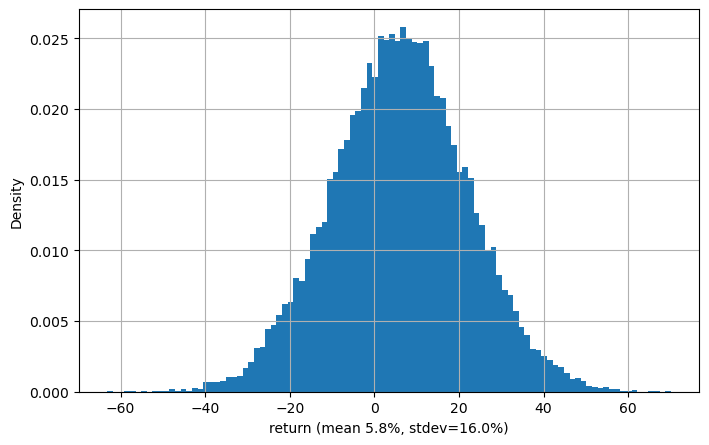

In [6]:
nsims = df.Sim.max()
plt.hist(df.Return[~df.Last],bins=nsims//10, density=True);
plt.xlabel(f'return (mean {df.Return.mean():.1f}%, stdev={df.Return[~df.Last].std():.1f}%)')
plt.ylabel('Density')
plt.grid(True)

In [8]:
f0 =  df.Surv1 &  df.Surv2 & df.Last  # event that we are both alive on 'last year'
f1 =  df.Surv1 & ~df.Surv2 & df.Last  # event that only I am alive on the 'last year'
f2 = ~df.Surv1 &  df.Surv2 & df.Last  # event that only C is alive on the 'last year'

for f in [f0, f1, f2]:
    pbankrupt = float(sum(df.TotAssets[f]==0))/sum(df.Last)
    print(100*pbankrupt)

21.3
6.7
13.700000000000001


/var/folders/vl/dthr92ys32bf3hjztkrbpsqm0000gn/T/ipykernel_12535/1002291551.py:10: RuntimeWarning: divide by zero encountered in log10
  plt.plot([np.log10(qv),np.log10(qv)],ylims,'k',linewidth=0.5)


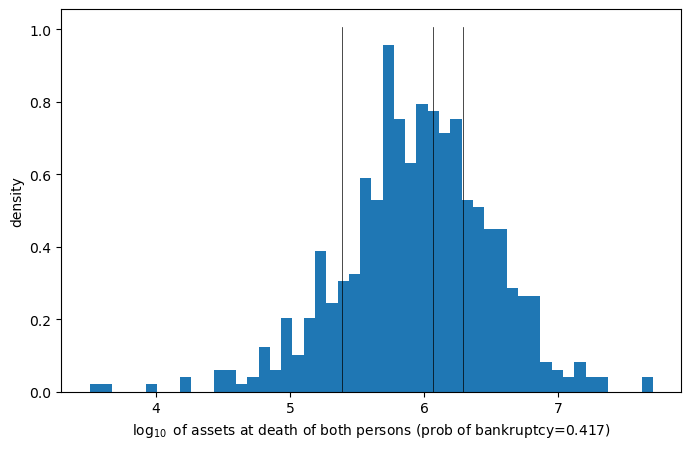

In [9]:
pbankrupt = float(sum(df.TotAssets[df.Last]==0))/sum(df.Last)
#print(pbankrupt)
plt.hist(df.TotAssets[df.Last&(df.TotAssets>0)].apply(np.log10),bins=nsims//20,density=True);
plt.xlabel(f'$\\log_{{10}}$ of assets at death of both persons (prob of bankruptcy={pbankrupt})');
plt.ylabel('density')
qs = [0.15,0.25,0.50,0.75,0.85]
quantiles = [df.TotAssets[df.Last].quantile(q) for q in qs]
ylims=plt.ylim()
for qv in quantiles:
    plt.plot([np.log10(qv),np.log10(qv)],ylims,'k',linewidth=0.5)

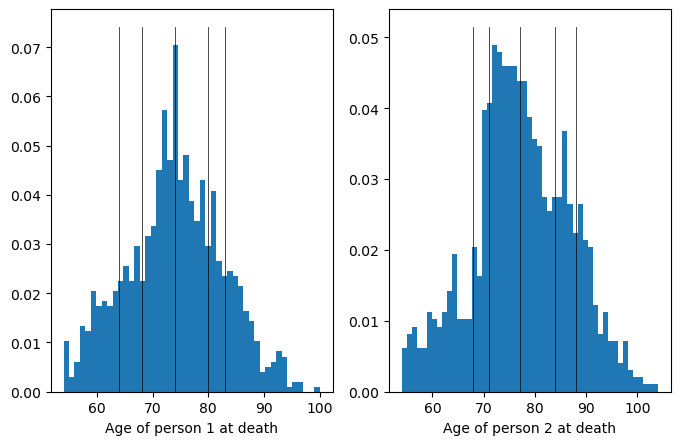

In [10]:
fig, axs = plt.subplots(1,2)
for ipers in [1,2]:
    ax = axs[ipers-1]
    col_name = f'A{ipers}'
    age = df[col_name]
    nbins = max(age) - min(age) + 1
    ax.hist(age[df.Last],bins=nbins,density=True)
    ax.set_xlabel(f'Age of person {ipers} at death')
    quantiles = [age[df.Last].quantile(q) for q in qs]
    ylims=ax.get_ylim()
    for qv in quantiles:
        ax.plot([qv,qv],ylims,'k',linewidth=0.5)

In [11]:
#
# find examples where we failed (ran out of money before we both died)
# and then figure out what happened
#
# 1) did we just live too long?
# 2) crappy stock returns?
# 3) paid too much in taxes? (we can start tapping the 401k money at 59 1/2)
#
# Required Minimum Distribution (RMD) - still haven't built this in to the stuff.
#
df_fails = df[(df.TotAssets==0) & df.Last][['Sim']]
df_fails['Fail'] = True
gb = df[~df.Last][['Sim','Withdraw','Taxes','Return','Year']].groupby(by='Sim')
df2 = gb.agg(func={'Withdraw':'sum', 
                   'Taxes':'sum',
                   'Return':np.mean,
                   'Year':len})
df2['AvgTaxPerYear'] = df2['Taxes']/df2['Year']
df2 = df2.merge(df_fails,how='left',on='Sim')
df2.Fail = df2.Fail.apply(lambda xx: True if xx==True else False)

/var/folders/vl/dthr92ys32bf3hjztkrbpsqm0000gn/T/ipykernel_12535/2560841821.py:14: FutureWarning: The provided callable <function mean at 0x117c3bba0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df2 = gb.agg(func={'Withdraw':'sum',


In [12]:
print(len(df2.Sim[df2.Fail].tolist()))
print(df2.Sim[df2.Fail].tolist())

417
[3, 6, 8, 12, 13, 15, 16, 20, 21, 23, 26, 27, 30, 32, 34, 37, 38, 44, 46, 47, 49, 51, 54, 55, 57, 61, 63, 64, 66, 67, 68, 72, 73, 75, 78, 79, 86, 87, 89, 90, 91, 93, 97, 100, 102, 104, 109, 111, 112, 113, 117, 120, 121, 124, 125, 127, 130, 142, 144, 148, 149, 150, 153, 155, 156, 164, 174, 176, 177, 187, 190, 192, 193, 194, 196, 198, 204, 207, 208, 209, 213, 214, 216, 217, 225, 226, 229, 232, 235, 236, 237, 241, 242, 246, 249, 252, 256, 257, 258, 259, 260, 263, 264, 266, 269, 273, 276, 277, 281, 282, 285, 286, 288, 289, 292, 297, 301, 303, 307, 310, 313, 318, 320, 322, 323, 324, 326, 328, 329, 333, 335, 337, 339, 342, 343, 344, 346, 348, 349, 351, 353, 354, 360, 361, 363, 365, 370, 371, 377, 378, 379, 380, 381, 383, 387, 389, 390, 392, 399, 400, 402, 407, 409, 410, 412, 416, 420, 422, 424, 425, 427, 428, 429, 432, 440, 446, 450, 453, 462, 463, 464, 465, 468, 471, 475, 479, 481, 483, 488, 489, 492, 496, 497, 500, 503, 504, 507, 510, 515, 518, 519, 522, 523, 527, 528, 529, 531, 533, 5

In [13]:
from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter, FuncFormatter

def plot_sim(df=df[df.Sim==3115]):
    df = df[:-1]
    fig, axs = plt.subplots(4,1,figsize=(13,8))
    axs[0].stackplot(df.Year, [df.Cash401k, df.PstTaxCash, df.Stock401k, df.PstTaxStok], labels=['cash401k','cash','stock401k','stock'])
    axs[0].legend()
    axs[0].set_xlim([2022,2078])
    axs[0].yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))
    
    axs[1].plot(df.Year, df.Withdraw, label='withdraw')
    axs[1].plot(df.Year, df.Spend, label='spend')
    axs[1].plot(df.Year, df.RMD, label='RMD')
    axs[1].legend()
    axs[1].yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))
    axs[1].set_xlim([2022,2078])
    
    axs[2].bar(df.Year, df.SSN, label='Social Security')
    axs[2].bar(df.Year, df.Ins, label='Insurance')
    axs[2].set_xlim([2022,2078])
    axs[2].legend()
    axs[2].yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))

    axs[3].plot(df.Year, df.Taxes, label='Taxes')
    axs[3].set_xlim([2022,2078])
    axs[3].legend()
    axs[3].yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))
    
    for yr, surv1 in zip(df.Year, df.Surv1):
        if not surv1:
            axs[0].axvline(yr,color='blue')
            print('1 dies in year', yr)
            break
    for yr, surv2 in zip(df.Year, df.Surv2):
        if not surv2:
            axs[0].axvline(yr,color='red')
            print('2 dies in year', yr)
            break

1 dies in year 2058


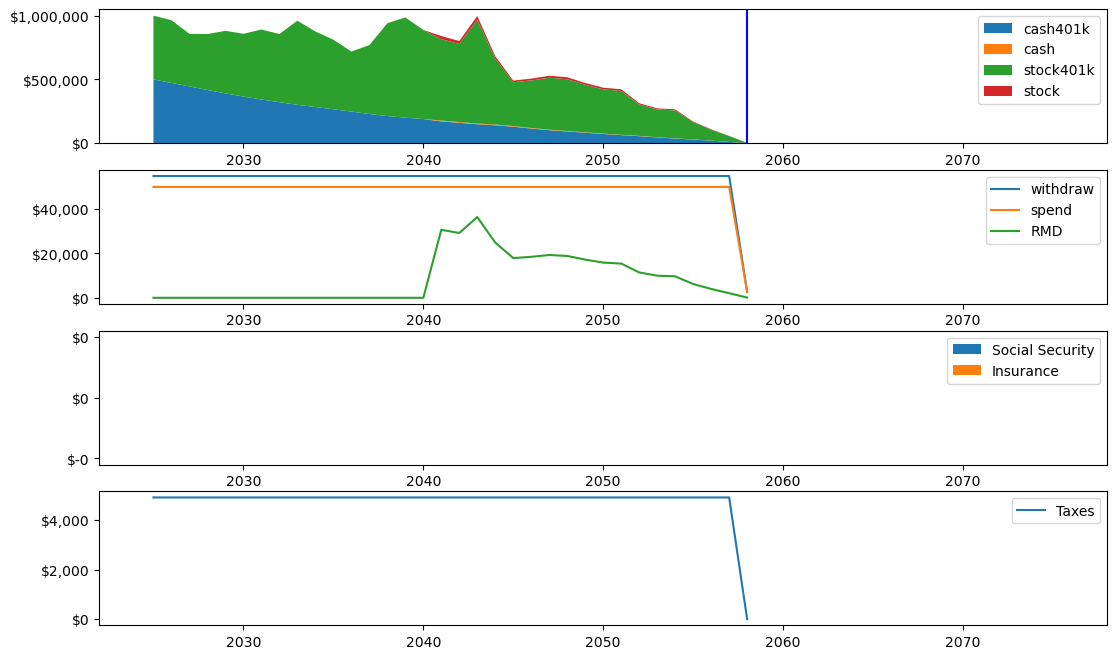

In [14]:
plot_sim(df[df.Sim==623])

In [15]:
df[df.Sim==623]

,Sim,Year,A1,A2,Surv1,Surv2,Cash401k,Stock401k,PstTaxCash,PstTaxStok,CashBasis,StockBasis,Spend,Withdraw,Taxable,Return,SSN,Ins,RMD,CarryFwd,TotAssets,Last,CashAlloc,Taxes
17625,623,2025,54,54,True,True,"500,000.00","500,000.00",0.00,0.00,0.00,0.00,"50,000.00","54,902.86","54,902.86",4.02,0.00,0.00,0.00,0.00,"1,000,000.00",False,0.50,"4,902.86"
17626,623,2026,55,55,True,True,"472,548.57","491,923.55",0.00,0.00,0.00,0.00,"50,000.00","54,902.86","54,902.86",-11.89,0.00,0.00,0.00,0.00,"964,472.12",False,0.49,"4,902.86"
17627,623,2027,56,56,True,True,"445,648.60","411,920.87",0.00,0.00,0.00,0.00,"50,000.00","54,902.86","54,902.86",12.90,0.00,0.00,0.00,0.00,"857,569.47",False,0.52,"4,902.86"
17628,623,2028,57,57,True,True,"417,117.52","438,622.70",0.00,0.00,0.00,0.00,"50,000.00","54,902.86","54,902.86",17.85,0.00,0.00,0.00,0.00,"855,740.22",False,0.49,"4,902.86"
17629,623,2029,58,58,True,True,"390,355.96","490,717.90",0.00,0.00,0.00,0.00,"50,000.00","54,902.86","54,902.86",6.68,0.00,0.00,0.00,0.00,"881,073.86",False,0.44,"4,902.86"
17630,623,2030,59,59,True,True,"366,031.48","491,914.44",0.00,0.00,0.00,0.00,"50,000.00","54,902.86","54,902.86",17.50,0.00,0.00,0.00,0.00,"857,945.92",False,0.43,"4,902.86"
17631,623,2031,60,60,True,True,"342,607.89","548,469.00",0.00,0.00,0.00,0.00,"50,000.00","54,902.86","54,902.86",3.80,0.00,0.00,0.00,0.00,"891,076.89",False,0.38,"4,902.86"
17632,623,2032,61,61,True,True,"321,498.43","534,605.92",0.00,0.00,0.00,0.00,"50,000.00","54,902.86","54,902.86",27.64,0.00,0.00,0.00,0.00,"856,104.36",False,0.38,"4,902.86"
17633,623,2033,62,62,True,True,"300,880.40","659,624.83",0.00,0.00,0.00,0.00,"50,000.00","54,902.86","54,902.86",-4.87,0.00,0.00,0.00,0.00,"960,505.23",False,0.31,"4,902.86"
17634,623,2034,63,63,True,True,"283,681.96","592,331.81",0.00,0.00,0.00,0.00,"50,000.00","54,902.86","54,902.86",-1.73,0.00,0.00,0.00,0.00,"876,013.77",False,0.32,"4,902.86"
